In [31]:
import torch
import torchvision.models as models
from torch import nn, optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchsampler import ImbalancedDatasetSampler
import os
import matplotlib.pyplot as plt


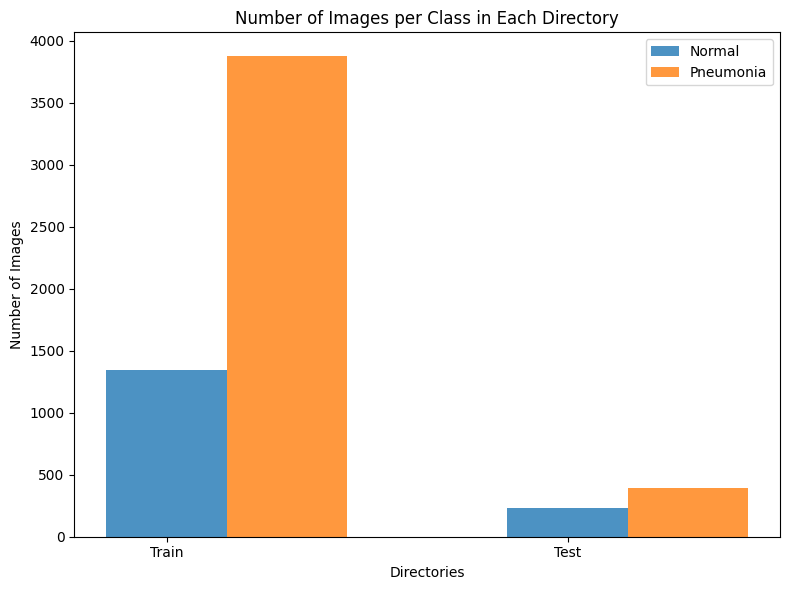

In [34]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'

# Count the number of images per class for each directory
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
val_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
val_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))

# Create the plot
classes = ['Normal', 'Pneumonia']
# directories = ['Train', 'Test', 'Validation']
directories = ['Train', 'Test']

# image_counts = [
#     [train_normal, test_normal, val_normal],
#     [train_pneumonia, test_pneumonia, val_pneumonia]
# ]

image_counts = [
    [train_normal, test_normal],
    [train_pneumonia, test_pneumonia]
]

fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.3
opacity = 0.8

for i, count in enumerate(image_counts):
    x = range(len(directories))
    x_shifted = [val + bar_width * i for val in x]
    ax.bar(x_shifted, count, bar_width, alpha=opacity, label=classes[i])

ax.set_xlabel('Directories')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in Each Directory')
ax.set_xticks(x)
ax.set_xticklabels(directories)
ax.legend()

plt.tight_layout()
plt.show()


In [25]:
# Hyperparameters
learning_rate = 1e-5
batch_size = 50
NUM_EPOCHS = 10
momentum = 0.9
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.BCELoss()
BATCH_TO_PRINT = 1000
weight_decay = 0.001

In [23]:
train_loss_values = []
validate_accuracy_values = []  

# Tolerance for early stopping
tolerance = 3

def train_model(data_loader, network, optimizer, criterion, num_epochs=NUM_EPOCHS):
    network = network.to(device)
    network.train()

    best_accuracy = 0.0
    best_model_weights = None
    best_epoch = 0

    for epoch in range(num_epochs):
        running_loss = epoch_loss = 0.0

        for i, data in enumerate(data_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()

            if i % BATCH_TO_PRINT == (BATCH_TO_PRINT - 1):
                print('[Epoch %d, Batch %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / BATCH_TO_PRINT))
                running_loss = 0.0

        writer.add_scalar(f'Loss/train:', epoch_loss / len(data_loader), epoch)
        print(f"[{epoch + 1}] loss: {epoch_loss / len(data_loader):.3f}")

        train_loss_values.append(epoch_loss / len(data_loader))

        validation_accuracy = validate_model(val_data_loader, network)
        validate_accuracy_values.append(validation_accuracy)  # Append validation accuracy to the list
        
        if validation_accuracy >= best_accuracy:
            best_accuracy = validation_accuracy
            best_model_weights = network.state_dict()
            best_epoch = epoch

        if epoch - best_epoch > tolerance:
            print("Early stopping. No improvement in validation accuracy.")
            break

        writer.add_scalar('Accuracy/validation', validation_accuracy, epoch)

    # Load the best model weights
    network.load_state_dict(best_model_weights)
    writer.flush()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 2), train_loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 2), validate_accuracy_values)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.show()

    return network

def validate_model(data_loader, network):
    network = network.to(device)
    network.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    print(F'Validation accuracy: {validation_accuracy:.2f}%')
    return validation_accuracy


def test_model(data_loader, network):
    network = network.to(device)
    network.eval()
    correct = 0
    total = 0
    test_labels = []
    test_predictions = []

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_labels.extend(labels.cpu().numpy())
            test_predictions.extend(predicted.cpu().numpy())

    print(F'Test accuracy: {(100 * correct / total):.2f}%')

    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    confusion_mat = confusion_matrix(test_labels, test_predictions)

    print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(accuracy, precision, recall, f1))
    print("Confusion Matrix:")
    print(confusion_mat)

    class_labels = ['Normal', 'Pneumonia',]  # Replace with your actual class labels

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

In [24]:
densenet = models.densenet121(weights='IMAGENET1K_V1')
# optimizer = optim.SGD(densenet.parameters(), lr=learning_rate, momentum=momentum)

optimizer = optim.Adam(densenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)

for param in densenet.parameters():
    param.requires_grad = True

num_classes = 2 
densenet.classifier = torch.nn.Linear(in_features=1024, out_features=num_classes)

In [9]:


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)
balanced_sampler = ImbalancedDatasetSampler(train_dataset)

# train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=balanced_sampler, num_workers=2)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

[1] loss: 0.093
Validation accuracy: 81.25%
[2] loss: 0.111
Validation accuracy: 87.50%
[3] loss: 0.030
Validation accuracy: 100.00%
[4] loss: 0.046
Validation accuracy: 100.00%
[5] loss: 0.023
Validation accuracy: 93.75%
[6] loss: 0.042
Validation accuracy: 100.00%
[7] loss: 0.014
Validation accuracy: 93.75%
[8] loss: 0.022
Validation accuracy: 100.00%
[9] loss: 0.009
Validation accuracy: 87.50%
[10] loss: 0.006
Validation accuracy: 100.00%


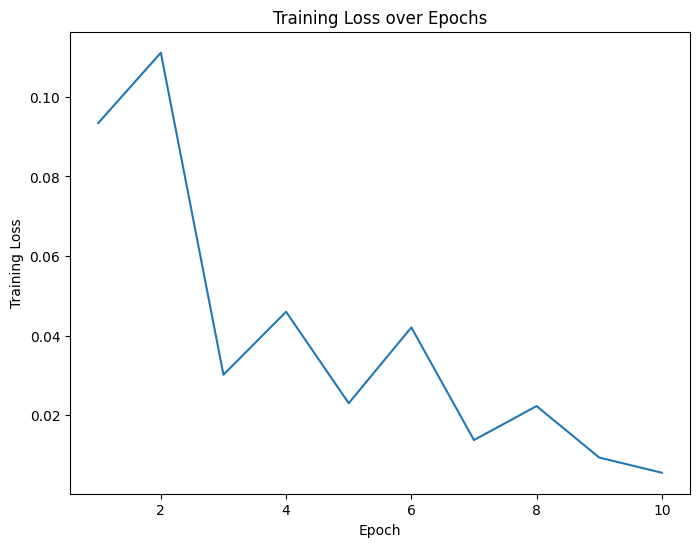

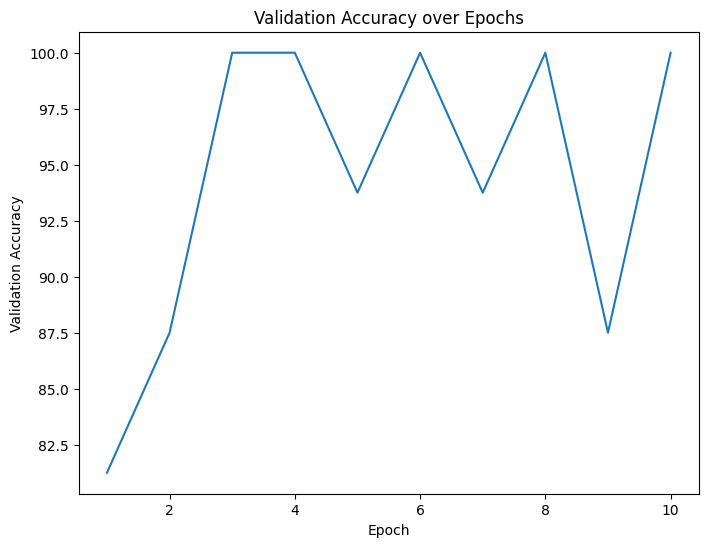

In [26]:
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

writer = SummaryWriter()
trained_network = train_model(train_data_loader, densenet, optimizer, loss_function)
object_to_save = {
    'model_state_dict': trained_network.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(object_to_save, 'densenet-fine-tuned.pt')


Test accuracy: 87.66%
Accuracy: 0.8766, Precision: 0.8941, Recall: 0.8766, F1-Score: 0.8705
Confusion Matrix:
[[159  75]
 [  2 388]]


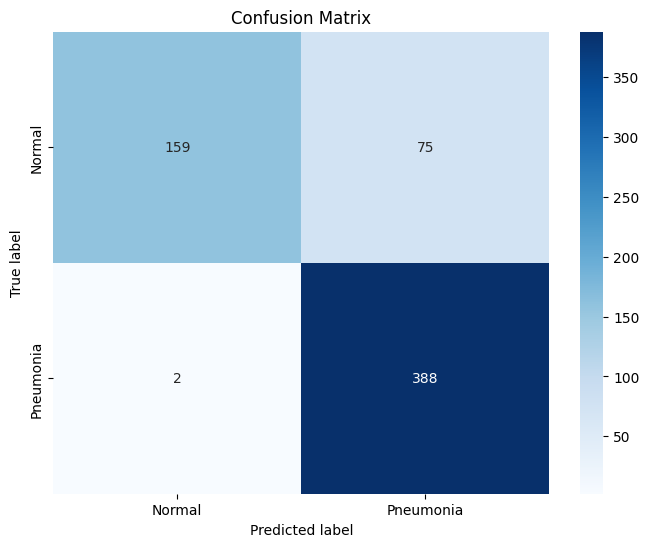

In [27]:
test = test_model(test_data_loader, trained_network)